In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
import scipy.stats as sps
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import make_scorer

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler


# Load Dataset

In [2]:
data = pd.read_csv('after_feature_creation.csv')
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,merch_zip_count_1_by_7,merch_zip_amount_1_by_7,merch_zip_count_1_by_14,merch_zip_amount_1_by_14,merch_zip_count_1_by_30,merch_zip_amount_1_by_30,dow,dow_risk,U*_by_merchnum,U*_by_cardnum
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,7.0,7.0,14.0,14.0,30.0,30.0,4,0.025994,1.143491,2.178008
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,P,31.42,0,...,7.0,7.0,14.0,14.0,30.0,30.0,4,0.025994,1.000000,1.604857
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,...,7.0,7.0,14.0,14.0,30.0,30.0,4,0.025994,1.025818,2.368143
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,...,7.0,7.0,14.0,14.0,30.0,30.0,4,0.025994,1.143491,1.044105
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,7.0,7.0,14.0,14.0,30.0,30.0,4,0.025994,1.143491,2.178008


In [3]:
data.drop(columns = ['Cardnum','Merchnum', 'Merch description', 'Merch state', 'Merch zip',
       'Transtype', 'Merch', 'state_zip', 'card_merch', 'card_description',
       'card_state', 'card_zip', 'merch_state', 'merch_zip'],inplace=True)

In [4]:
data.head(1)

,Recnum,Date,Amount,Fraud,Cardnum_count_0,avg_Amount_Cardnum_0,actual_by_avg_Amount_Cardnum_0,max_Amount_Cardnum_0,actual_by_max_Amount_Cardnum_0,med_Amount_Cardnum_0,...,merch_zip_count_1_by_7,merch_zip_amount_1_by_7,merch_zip_count_1_by_14,merch_zip_amount_1_by_14,merch_zip_count_1_by_30,merch_zip_amount_1_by_30,dow,dow_risk,U*_by_merchnum,U*_by_cardnum
0,1,2010-01-01,3.62,0,11,3.624545,0.998746,3.67,0.986376,3.62,...,7.0,7.0,14.0,14.0,30.0,30.0,4,0.025994,1.143491,2.178008


In [5]:
data.shape

(96397, 860)

# Data Preprocessing

In [11]:
%%time
# remove the first 2 weeks and the last 2 months data in 2010
# because data of first 2 weeks may not be robust and data of last 2 month is for validation

df = data.loc[(data['Date']>'2010-01-14')].copy()

# Remove non-variable columns 
df.drop(columns=['Date','Fraud','Amount'],inplace=True)

# Standarize variables first to speed up converging in wrapper (backward selection) 
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df.columns
df_scaled['Date'] = data.loc[(data['Date']>'2010-01-14')]['Date'].values
df_scaled['Fraud'] = data.loc[(data['Date']>'2010-01-14')]['Fraud'].values
df_scaled['Amount'] = data.loc[(data['Date']>'2010-01-14')]['Amount'].values


# Add a random variable ~ N(0,1)
dist = norm(0,1)
df_scaled['RANDOM'] = dist.rvs(size = df.shape[0])

# Set the data from the last two months in 2010 as out of time (OOT) data
oot = df_scaled.loc[df_scaled['Date']>='2010-11-01']
tt = df_scaled.loc[df_scaled['Date']<'2010-11-01']

print(f'oot.shape: {oot.shape}')
print(f'tt.shape: {tt.shape}')

oot.shape: (12427, 861)
tt.shape: (80632, 861)
CPU times: user 3.48 s, sys: 2.94 s, total: 6.43 s
Wall time: 7.5 s


# Feature Selection

## Filter

### KS

In [14]:
%%time
goods = tt[tt['Fraud']==0]
bads = tt[tt['Fraud']==1]
cols = list(tt.columns)
cols.remove('Date')
cols.remove('Amount')
KSFDR = pd.DataFrame()

for var in cols:
    KSFDR.loc[var,'ks'] = sps.ks_2samp(goods[var],bads[var])[0]
    KSFDR.loc[var,'ks_pvalue'] = sps.ks_2samp(goods[var],bads[var])[1]

CPU times: user 17.3 s, sys: 462 ms, total: 17.7 s
Wall time: 17.8 s


In [15]:
KSFDR.sort_values('ks',ascending=False)

,ks,ks_pvalue
Fraud,1.000000,0.000000
total_Amount_card_state_14,0.690795,0.000000
total_Amount_card_description_14,0.688906,0.000000
total_Amount_card_state_7,0.688753,0.000000
total_Amount_card_merch_14,0.688040,0.000000
...,...,...
card_zip_amount_0_by_30,0.076420,0.000083
card_zip_amount_1_by_7,0.066737,0.000904
card_merch_amount_1_by_14,0.059131,0.004718
card_state_amount_1_by_7,0.056382,0.008162


### FDR at 3%

In [16]:
%%time
topRows = int(round(len(tt)*0.03))
numbads = bads.shape[0]
for var in cols:
    if var =='Fraud':
        temp = tt[[var]]
    else:
        temp = tt[[var,'Fraud']]
    temp0 = temp.sort_values(var)
    temp1 = temp0.head(numbads)
    temp2 = temp0.tail(numbads)
    needed1 = temp1.loc[:,'Fraud']
    needed2 = temp2.loc[:,'Fraud']
    FDR1 = sum(needed1)/numbads
    FDR2 = sum(needed2)/numbads
    FDRate = max(FDR1,FDR2)
    KSFDR.loc[var,'FDR at 3%'] = FDRate

CPU times: user 6.52 s, sys: 37.6 ms, total: 6.55 s
Wall time: 6.58 s


In [17]:
KSFDR.sort_values('FDR at 3%',ascending=False)

,ks,ks_pvalue,FDR at 3%
Fraud,1.000000,0.000000e+00,1.000000
total_Amount_Cardnum_1,0.576299,6.723441e-271,0.447005
total_Amount_Cardnum_3,0.588905,3.518669e-284,0.447005
max_Amount_card_merch_7,0.656993,0.000000e+00,0.430876
max_Amount_card_description_7,0.662865,0.000000e+00,0.428571
...,...,...,...
state_zip_amount_1_by_30,0.362038,2.273063e-101,0.000000
merch_zip_count_7,0.285021,2.991473e-62,0.000000
Cardnum_count_3,0.455012,5.055294e-163,0.000000
actual_by_total_Amount_Merch zip_0,0.258614,3.692733e-51,0.000000


### Sort ks and FDR by average rank

In [18]:
KSFDR['rank_ks'] = KSFDR['ks'].rank(ascending=True)
KSFDR['rank_FDR'] = KSFDR['FDR at 3%'].rank(ascending=True)
KSFDR['avg_rank'] = (KSFDR['rank_ks']+KSFDR['rank_FDR'])/2
KSFDR.sort_values('avg_rank',ascending=False,inplace=True)
KSFDR.iloc[:81,:]

,ks,ks_pvalue,FDR at 3%,rank_ks,rank_FDR,avg_rank
Fraud,1.000000,0.000000e+00,1.000000,859.0,859.0,859.00
max_Amount_card_description_7,0.662865,0.000000e+00,0.428571,842.0,854.5,848.25
max_Amount_card_description_14,0.666364,0.000000e+00,0.421659,843.0,850.5,846.75
max_Amount_card_merch_14,0.661770,0.000000e+00,0.421659,840.0,850.5,845.25
max_Amount_card_zip_7,0.659881,0.000000e+00,0.428571,836.0,854.5,845.25
...,...,...,...,...,...,...
avg_Amount_card_description_0,0.584389,2.259993e-279,0.277650,784.0,772.0,778.00
avg_Amount_card_description_30,0.606384,2.531425e-303,0.275346,810.0,745.5,777.75
avg_Amount_card_description_1,0.594267,5.826779e-290,0.276498,795.0,759.5,777.25
avg_Amount_Cardnum_1,0.575903,1.726736e-270,0.283410,770.0,784.0,777.00


In [19]:
%%time
KSFDR.iloc[:81,:].to_csv('80 variables.csv')

CPU times: user 2.49 ms, sys: 1.68 ms, total: 4.16 ms
Wall time: 4.19 ms


In [20]:
# choose top 81 (top80+fraud_label)
var_list = KSFDR.reset_index().iloc[:81,:].rename(columns = {'index':'Variable'})['Variable']
var_list

0                              Fraud
1      max_Amount_card_description_7
2     max_Amount_card_description_14
3           max_Amount_card_merch_14
4              max_Amount_card_zip_7
                   ...              
76     avg_Amount_card_description_0
77    avg_Amount_card_description_30
78     avg_Amount_card_description_1
79              avg_Amount_Cardnum_1
80          avg_Amount_card_merch_30
Name: Variable, Length: 81, dtype: object

In [21]:
var1 = tt.loc[:,var_list]
var1.head()

,Fraud,max_Amount_card_description_7,max_Amount_card_description_14,max_Amount_card_merch_14,max_Amount_card_zip_7,max_Amount_card_merch_7,max_Amount_card_zip_14,max_Amount_card_description_3,max_Amount_card_zip_3,max_Amount_card_state_7,...,max_Amount_merch_zip_1,avg_Amount_card_merch_0,avg_Amount_card_zip_7,max_Amount_state_zip_0,avg_Amount_card_zip_0,avg_Amount_card_description_0,avg_Amount_card_description_30,avg_Amount_card_description_1,avg_Amount_Cardnum_1,avg_Amount_card_merch_30
0,0,0.469290,0.440977,0.441194,0.458316,0.470759,0.425108,-0.117639,-0.122634,0.352939,...,-0.245916,-0.079789,0.319239,-0.258078,-0.079970,-0.079903,0.316190,-0.081460,0.176760,0.314334
1,0,-0.429538,-0.440934,-0.437938,-0.433489,-0.427605,-0.447242,-0.416658,-0.420489,-0.465139,...,-0.476531,-0.492265,-0.502507,-0.103519,-0.493381,-0.493071,-0.511990,-0.493455,-0.548639,-0.508631
2,0,-0.149275,0.050947,0.051429,-0.156938,-0.149020,0.038350,-0.134257,-0.139187,-0.163799,...,-0.259326,-0.193501,-0.245172,-0.272378,-0.193939,-0.193778,-0.197211,-0.238669,-0.091722,-0.195633
3,0,-0.429538,-0.440934,-0.437938,-0.433489,-0.427605,-0.447242,-0.416658,-0.420489,-0.465139,...,-0.476531,-0.492265,-0.502507,-0.103519,-0.493381,-0.493071,-0.511990,-0.493455,-0.548639,-0.508631
4,0,-0.426500,-0.437954,-0.437139,-0.432679,-0.426789,-0.446449,-0.413598,-0.417441,-0.464396,...,-0.484754,-0.477265,-0.487813,-0.512751,-0.478346,-0.477948,-0.497071,-0.478376,-0.568147,-0.493487


In [22]:
var_list.values

array(['Fraud', 'max_Amount_card_description_7',
       'max_Amount_card_description_14', 'max_Amount_card_merch_14',
       'max_Amount_card_zip_7', 'max_Amount_card_merch_7',
       'max_Amount_card_zip_14', 'max_Amount_card_description_3',
       'max_Amount_card_zip_3', 'max_Amount_card_state_7',
       'max_Amount_card_merch_3', 'total_Amount_card_description_14',
       'max_Amount_card_zip_30', 'max_Amount_card_description_30',
       'max_Amount_card_state_3', 'max_Amount_card_merch_30',
       'total_Amount_card_description_30',
       'total_Amount_card_description_7', 'max_Amount_card_description_1',
       'max_Amount_card_zip_1', 'max_Amount_card_state_1',
       'max_Amount_card_merch_1', 'total_Amount_card_state_1',
       'total_Amount_Cardnum_7', 'total_Amount_card_state_3',
       'total_Amount_card_description_3', 'total_Amount_card_zip_3',
       'total_Amount_card_state_14', 'total_Amount_card_zip_30',
       'max_Amount_card_state_0', 'max_Amount_card_zip_0',
    

## Wrapper

### Forward Selection

In [56]:
def get_fdr(model, X, y):
    y_pred = model.predict_proba(X)[:, 1]
    temp = pd.DataFrame({'y': y, 'y_pred': y_pred})
    numbads = y.sum()
    temp = temp.sort_values('y_pred', ascending=False)
    target_num = int(temp.shape[0] * 0.03)
    temp = temp.iloc[:target_num, :]
    detect_bads = temp['y'].sum()
    fdr = detect_bads / numbads
    return fdr

In [57]:
%%time
# First round wrapper
X = var1.iloc[:,1:]
y = var1.iloc[:,0]
lr = LogisticRegression(penalty = 'l2', class_weight = 'balanced',max_iter=10000)

sfs = SFS(lr, forward=True, k_features=79, verbose=2, scoring = get_fdr, cv=0, n_jobs=2)
sfs.fit(X,y)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:    6.1s finished

[2021-04-24 15:10:52] Features: 1/79 -- score: 0.5046082949308756[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    4.4s finished

[2021-04-24 15:10:57] Features: 2/79 -- score: 0.6705069124423964[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done  78 out of  78 | elapsed:    5.5s finished

[2021-04-24 15:11:02] Features: 3/79 -- score: 0.684331797235023[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done  77 out of  77 | elaps

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  2.1min finished

[2021-04-24 15:39:28] Features: 31/79 -- score: 0.706221198156682[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  49 out of  49 | elapsed:  1.6min finished

[2021-04-24 15:41:02] Features: 32/79 -- score: 0.706221198156682[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:  1.9min finished

[2021-04-24 15:42:57] Features: 33/79 -- score: 0.706221198156682[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  47 out of  47 | elapsed:  2.0min finished

[2021-04-24 15:44:59] Features: 34/79 -- score: 0.70

[Parallel(n_jobs=2)]: Done  14 out of  14 | elapsed:  1.2min finished

[2021-04-24 16:42:40] Features: 67/79 -- score: 0.6820276497695853[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  13 out of  13 | elapsed:  1.1min finished

[2021-04-24 16:43:44] Features: 68/79 -- score: 0.6820276497695853[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:  1.1min finished

[2021-04-24 16:44:47] Features: 69/79 -- score: 0.6820276497695853[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  11 out of  11 | elapsed:   56.3s finished

[2021-04-24 16:45:44] Features: 70/79 -- score: 0.6820276497695853[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   53.2s finished

[2021-04-24 16:46:37] Features: 71/79 -- score: 0.6820276497695853[Parallel(n_job

CPU times: user 38 s, sys: 39.7 s, total: 1min 17s
Wall time: 1h 39min 46s


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   11.5s finished

[2021-04-24 16:50:32] Features: 79/79 -- score: 0.7073732718894009

SequentialFeatureSelector(cv=0,
                          estimator=LogisticRegression(class_weight='balanced',
                                                       max_iter=10000),
                          k_features=79, n_jobs=2,
                          scoring=<function get_fdr at 0x7ff54c58c310>,
                          verbose=2)

In [58]:
sfs.k_feature_names_

('max_Amount_card_description_7',
 'max_Amount_card_description_14',
 'max_Amount_card_merch_14',
 'max_Amount_card_zip_7',
 'max_Amount_card_merch_7',
 'max_Amount_card_zip_14',
 'max_Amount_card_description_3',
 'max_Amount_card_zip_3',
 'max_Amount_card_state_7',
 'max_Amount_card_merch_3',
 'total_Amount_card_description_14',
 'max_Amount_card_zip_30',
 'max_Amount_card_description_30',
 'max_Amount_card_state_3',
 'max_Amount_card_merch_30',
 'total_Amount_card_description_30',
 'total_Amount_card_description_7',
 'max_Amount_card_description_1',
 'max_Amount_card_zip_1',
 'max_Amount_card_state_1',
 'max_Amount_card_merch_1',
 'total_Amount_card_state_1',
 'total_Amount_Cardnum_7',
 'total_Amount_card_state_3',
 'total_Amount_card_description_3',
 'total_Amount_card_zip_3',
 'total_Amount_card_state_14',
 'total_Amount_card_zip_30',
 'max_Amount_card_state_0',
 'max_Amount_card_zip_0',
 'max_Amount_card_state_14',
 'total_Amount_card_merch_3',
 'max_Amount_card_description_0',
 '

In [59]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

/Users/yli/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yli/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(30,)",[0.5046082949308756],0.504608,"(max_Amount_card_state_14,)",NaN,0.0,NaN
2,"(16, 30)",[0.6705069124423964],0.670507,"(total_Amount_card_description_7, max_Amount_c...",NaN,0.0,NaN
3,"(16, 30, 47)",[0.684331797235023],0.684332,"(total_Amount_card_description_7, max_Amount_c...",NaN,0.0,NaN
4,"(16, 30, 47, 68)",[0.6970046082949308],0.697005,"(total_Amount_card_description_7, max_Amount_c...",NaN,0.0,NaN
5,"(16, 30, 33, 47, 68)",[0.7039170506912442],0.703917,"(total_Amount_card_description_7, max_Amount_c...",NaN,0.0,NaN
...,...,...,...,...,...,...,...
75,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[0.706221198156682],0.706221,"(max_Amount_card_description_7, max_Amount_car...",NaN,0.0,NaN
76,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[0.706221198156682],0.706221,"(max_Amount_card_description_7, max_Amount_car...",NaN,0.0,NaN
77,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[0.706221198156682],0.706221,"(max_Amount_card_description_7, max_Amount_car...",NaN,0.0,NaN
78,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[0.706221198156682],0.706221,"(max_Amount_card_description_7, max_Amount_car...",NaN,0.0,NaN


/Users/yli/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yli/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


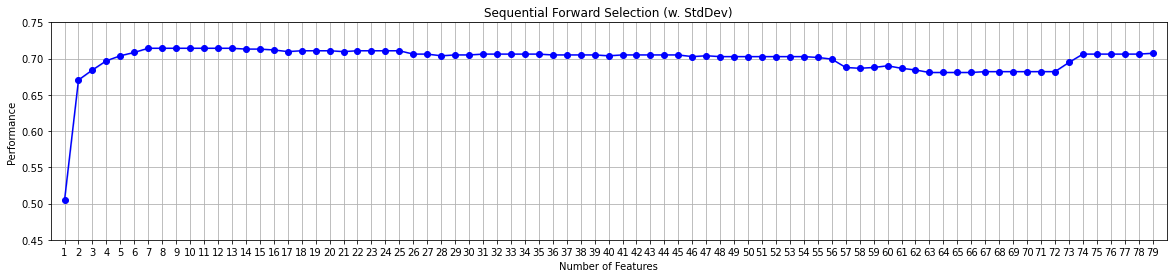

In [74]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev',figsize=(20,4))
plt.ylim([0.45,0.75])
plt.xlim(0,80)
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [81]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T.iloc[6]['feature_names']

/Users/yli/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yli/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


('total_Amount_card_description_7',
 'total_Amount_card_description_3',
 'max_Amount_card_state_14',
 'total_Amount_Cardnum_3',
 'total_Amount_card_description_0',
 'total_Amount_Cardnum_14',
 'max_Amount_Cardnum_3')

### Backward Selection

In [84]:
%%time
# First round wrapper
X = var1.iloc[:,1:]
y = var1.iloc[:,0]
lr = LogisticRegression(penalty = 'l2', class_weight = 'balanced',max_iter=1000)

sfs_2 = SFS(lr, forward=False, k_features=2, verbose=2, scoring = get_fdr, cv=0, n_jobs=2)
sfs_2.fit(X,y)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:  6.5min finished

[2021-04-24 17:22:59] Features: 79/2 -- score: 0.7119815668202765[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:  6.4min finished

[2021-04-24 17:29:23] Features: 78/2 -- score: 0.7142857142857143[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done  78 out of  78 | elapsed:  6.4min finished

[2021-04-24 17:35:46] Features: 77/2 -- score: 0.7142857142857143[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done  77 out of  77 | elap

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  2.4min finished

[2021-04-24 20:14:16] Features: 49/2 -- score: 0.7223502304147466[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  49 out of  49 | elapsed:  2.0min finished

[2021-04-24 20:16:15] Features: 48/2 -- score: 0.7223502304147466[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:  2.3min finished

[2021-04-24 20:18:31] Features: 47/2 -- score: 0.7223502304147466[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  47 out of  47 | elapsed:  2.3min finished

[2021-04-24 20:20:48] Features: 46/2 -- score: 0.722

[Parallel(n_jobs=2)]: Done  14 out of  14 | elapsed:    8.6s finished

[2021-04-24 20:55:19] Features: 13/2 -- score: 0.7315668202764977[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  13 out of  13 | elapsed:    6.1s finished

[2021-04-24 20:55:25] Features: 12/2 -- score: 0.7269585253456221[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    5.7s finished

[2021-04-24 20:55:31] Features: 11/2 -- score: 0.7246543778801844[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  11 out of  11 | elapsed:    4.3s finished

[2021-04-24 20:55:35] Features: 10/2 -- score: 0.7246543778801844[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    3.3s finished

[2021-04-24 20:55:39] Features: 9/2 -- score: 0.7188940092165899[Parallel(n_jobs=2)]:

CPU times: user 1min 20s, sys: 1min 9s, total: 2min 29s
Wall time: 3h 39min 26s


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.3s finished

[2021-04-24 20:55:47] Features: 2/2 -- score: 0.6486175115207373

SequentialFeatureSelector(cv=0,
                          estimator=LogisticRegression(class_weight='balanced',
                                                       max_iter=1000),
                          forward=False, k_features=2, n_jobs=2,
                          scoring=<function get_fdr at 0x7ff54c58c310>,
                          verbose=2)

In [85]:
pd.DataFrame.from_dict(sfs_2.get_metric_dict()).T

/Users/yli/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yli/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
80,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[0.7108294930875576],0.710829,"(max_Amount_card_description_7, max_Amount_car...",NaN,0.0,NaN
79,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[0.7119815668202765],0.711982,"(max_Amount_card_description_7, max_Amount_car...",NaN,0.0,NaN
78,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[0.7142857142857143],0.714286,"(max_Amount_card_description_7, max_Amount_car...",NaN,0.0,NaN
77,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[0.7142857142857143],0.714286,"(max_Amount_card_description_7, max_Amount_car...",NaN,0.0,NaN
76,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[0.7142857142857143],0.714286,"(max_Amount_card_description_7, max_Amount_car...",NaN,0.0,NaN
...,...,...,...,...,...,...,...
6,"(10, 30, 38, 41, 42, 51)",[0.7027649769585254],0.702765,"(total_Amount_card_description_14, max_Amount_...",NaN,0.0,NaN
5,"(30, 38, 41, 42, 51)",[0.6900921658986175],0.690092,"(max_Amount_card_state_14, total_Amount_card_z...",NaN,0.0,NaN
4,"(30, 38, 41, 51)",[0.6854838709677419],0.685484,"(max_Amount_card_state_14, total_Amount_card_z...",NaN,0.0,NaN
3,"(30, 38, 51)",[0.6543778801843319],0.654378,"(max_Amount_card_state_14, total_Amount_card_z...",NaN,0.0,NaN


/Users/yli/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yli/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


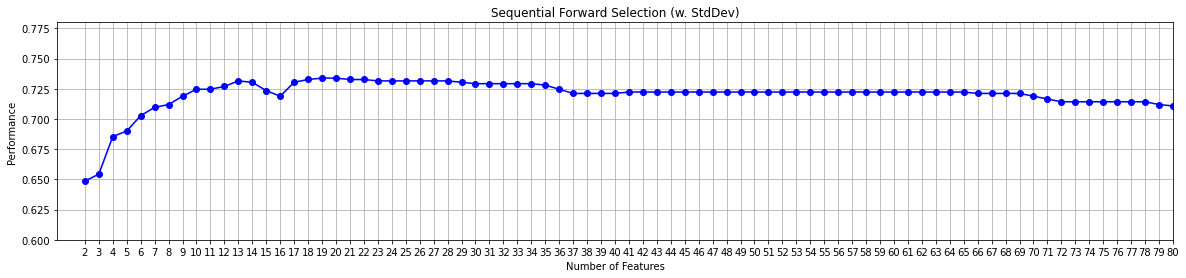

In [87]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs_2.get_metric_dict(),kind='std_dev',figsize=(20,4))
plt.ylim([0.6,0.78])
plt.xlim(0,80)
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [89]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T.iloc[19]['feature_names']

/Users/yli/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yli/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


('total_Amount_card_description_7',
 'total_Amount_Cardnum_7',
 'total_Amount_card_description_3',
 'max_Amount_card_state_0',
 'max_Amount_card_state_14',
 'total_Amount_Cardnum_3',
 'total_Amount_card_description_1',
 'total_Amount_Cardnum_1',
 'total_Amount_Cardnum_0',
 'total_Amount_card_description_0',
 'total_Amount_Cardnum_14',
 'max_Amount_card_state_30',
 'max_Amount_Cardnum_0',
 'avg_Amount_card_state_3',
 'avg_Amount_card_zip_1',
 'max_Amount_Cardnum_3',
 'avg_Amount_card_zip_7',
 'avg_Amount_card_description_30',
 'avg_Amount_card_description_1',
 'avg_Amount_card_merch_30')

In [92]:
final_features = ['total_Amount_card_description_7',
 'total_Amount_Cardnum_7',
 'total_Amount_card_description_3',
 'max_Amount_card_state_0',
 'max_Amount_card_state_14',
 'total_Amount_Cardnum_3',
 'total_Amount_card_description_1',
 'total_Amount_Cardnum_1',
 'total_Amount_Cardnum_0',
 'total_Amount_card_description_0',
 'total_Amount_Cardnum_14',
 'max_Amount_card_state_30',
 'max_Amount_Cardnum_0',
 'avg_Amount_card_state_3',
 'avg_Amount_card_zip_1',
 'max_Amount_Cardnum_3',
 'avg_Amount_card_zip_7',
 'avg_Amount_card_description_30',
 'avg_Amount_card_description_1',
 'avg_Amount_card_merch_30']

In [109]:
final_columns = ['total_Amount_card_description_7',
 'total_Amount_Cardnum_7',
 'total_Amount_card_description_3',
 'max_Amount_card_state_0',
 'max_Amount_card_state_14',
 'total_Amount_Cardnum_3',
 'total_Amount_card_description_1',
 'total_Amount_Cardnum_1',
 'total_Amount_Cardnum_0',
 'total_Amount_card_description_0',
 'total_Amount_Cardnum_14',
 'max_Amount_card_state_30',
 'max_Amount_Cardnum_0',
 'avg_Amount_card_state_3',
 'avg_Amount_card_zip_1',
 'max_Amount_Cardnum_3',
 'avg_Amount_card_zip_7',
 'avg_Amount_card_description_30',
 'avg_Amount_card_description_1',
 'avg_Amount_card_merch_30',
 'Amount','Date','Fraud']

In [114]:
final_df = data.loc[:,final_columns]
final_df

,total_Amount_card_description_7,total_Amount_Cardnum_7,total_Amount_card_description_3,max_Amount_card_state_0,max_Amount_card_state_14,total_Amount_Cardnum_3,total_Amount_card_description_1,total_Amount_Cardnum_1,total_Amount_Cardnum_0,total_Amount_card_description_0,...,avg_Amount_card_state_3,avg_Amount_card_zip_1,max_Amount_Cardnum_3,avg_Amount_card_zip_7,avg_Amount_card_description_30,avg_Amount_card_description_1,avg_Amount_card_merch_30,Amount,Date,Fraud
0,293.22,438.57,293.22,3.67,3.67,438.57,293.22,438.57,438.57,293.22,...,3.624545,3.624545,3.67,3.624545,3.620,3.620,3.624545,3.62,2010-01-01,0
1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,31.420000,31.420000,31.42,31.420000,31.420,31.420,31.420000,31.42,2010-01-01,0
2,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,178.490000,178.490000,178.49,178.490000,178.490,178.490,178.490000,178.49,2010-01-01,0
3,93.20,182.84,93.20,3.80,3.80,182.84,93.20,182.84,182.84,93.20,...,3.731429,3.731429,3.80,3.731429,3.728,3.728,3.731429,3.62,2010-01-01,0
4,293.22,438.57,293.22,3.67,3.67,438.57,293.22,438.57,438.57,293.22,...,3.624545,3.624545,3.67,3.624545,3.620,3.620,3.624545,3.62,2010-01-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96392,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,...,84.790000,84.790000,84.79,84.790000,84.790,84.790,84.790000,84.79,2010-12-31,0
96393,118.75,6280.50,118.75,118.75,1385.00,6280.50,118.75,1607.50,1607.50,118.75,...,443.125000,118.750000,1478.00,118.750000,359.300,118.750,359.300000,118.75,2010-12-31,0
96394,363.56,2578.13,363.56,363.56,363.56,1689.92,363.56,1501.14,363.56,363.56,...,217.705000,363.560000,1065.73,363.560000,363.560,363.560,363.560000,363.56,2010-12-31,0
96395,2202.03,2202.03,2202.03,2202.03,2202.03,2202.03,2202.03,2202.03,2202.03,2202.03,...,2202.030000,2202.030000,2202.03,2202.030000,915.210,2202.030,915.210000,2202.03,2010-12-31,0


In [115]:
%%time
final_df.to_csv('after_feature_selection.csv',index=False)

CPU times: user 1.32 s, sys: 30.3 ms, total: 1.35 s
Wall time: 1.36 s
